___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://d33wubrfki0l68.cloudfront.net/4ec62c1c925a380c912ddad740d18554c6822a11/fabe4/img/sponsors/iteso-university.png" width="300" height="500" />

## Proyecto Final de Ética en la Ciencia de Datos

**Integrantes:**
- Sergio Daniel Dueñas Godinez - 739300
- Ricardo Damian Hernandez Ramirez - 740356
- Manuel Alejandro Murguía Orantes - 739360

**Fecha:** 10 de mayo del 2024.

**Profesor:** Renatta Garcia Sanchez
    
**Link a Github**: https://github.com/SergioDuenass/ProyectoEtica

## Bank Loan Approval

##### [Link de nuestro Dataset](https://www.kaggle.com/datasets/vikramamin/bank-loan-approval-lr-dt-rf-and-auc)

<div style="text-align: justify">
Como nuestro proyecto final de la matería Ética en la Ciencia de Datos nos quisimos enfocar en la transparencia y la equidad en el proceso de aprobación de préstamos bancarios en California, Estados Unidos. Utiizamos un conjunto de datos denominado 'bank loan approval', el cual contiene información detallada sobre diferentes individuos incluyendo:

 - Edad
 - Años de Experiencia Laboral
 - Ingresos Anuales (Expresado en miles)
 - Código Postal
 - Nivel de Educación

entre otras variables. Nuestro objetivo fue desarrollar un modelo predictivo que evaluara de manera justa y precisa la eligibilidad de una persona para recibir un préstamo.
<br>

**Índice**
1. [Presentación de Datos](#id1)
2. [Análisis Exploratorio (EDA)](#id2)
3. [Modelado y Selección de Modelo](#id3)
4. [Aplicación de Técnicas Fairness](#id4)
5. [Conclusiones](#id5)
</div>

<div id='id1'/>

## Presentación de Datos

#### Librerías

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
import pickle
import joblib
import json

from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pyzipcode import ZipCodeDatabase
from pycaret.classification import *
from sklearn.tree import DecisionTreeClassifier

from fairlearn.metrics import count, false_positive_rate, selection_rate, demographic_parity_difference, demographic_parity_ratio, equalized_odds_ratio
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

zcdb = ZipCodeDatabase()
warnings.filterwarnings("ignore")

#### Importación de Datos

In [3]:
df = pd.read_csv("../data/bankloan.csv")
df.head()

,ID,Age,Experience,Income,ZIP.Code,Family,CCAvg,Education,Mortgage,Personal.Loan,Securities.Account,CD.Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


##### Descripción de columnas:

- **ID**: ID del cliente.

- **Age**: Edad en años.

- **Experience**: Experiencia de trabajo en años.

- **Income**: Ingreso anual expresado en miles.

- **Zipcode**: Código postal de la vivienda del cliente.

- **Family**: Número de miembros en la familia.

- **CCAvg**: Promedio del gasto en su tarjeta de crédito al mes expresado en miles.

- **Education**: Nivel de educación
    - 1: Título de grado
    - 2: Título de maestría
    - 3: Títulos profesionales avanzados (PhD, MD, etc.)

- **Mortgage**: Valor de la hipoteca de su casa en miles.

- **Securities Account**: Si el cliente tiene una cuenta de valores en el banco como acciones.

- **CD Account**: Si el cliente tiene un certificado de cuenta de depósito (CD) en el banco.

- **Online**: Si el cliente usa las páginas del banco en línea.

- **CreditCard**: Usa una tarjeta de crédito emitida por el banco.

- **Personal Loan**: El cliente aceptó un préstamo personal en la campaña pasada.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP.Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal.Loan       5000 non-null   int64  
 10  Securities.Account  5000 non-null   int64  
 11  CD.Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


<div style="text-align: justify">
Vemos que no tenemos valores nulos y que todos nuestros datos son de tipo númerico. Realmente en esta parte no hay mucho que podamos hacer, más que presentar los datos, por lo que podemos pasar a la siguiente sección donde veremos de mejor manera la composición de nuestros datos y su comportamiento

<div id='id2'/>
    
## Análisis Exploratorio (EDA)

Primeramente, aunque no usaremos los códigos postales para nuestro modelo, pues atenta contra la moral, nos gustaría comprobar de donde son los códigos postales

In [5]:
zipCodeState = []
zipCodeCity = []

for i in df["ZIP.Code"]:
    try:
        zipcode = zcdb[i]
        zipCodeState.append(zipcode.state)
        zipCodeCity.append(zipcode.city)
    except KeyError:
        zipCodeState.append("notFound")
        zipCodeCity.append("notFound")

df["zipCodeCity"] = zipCodeCity
df["zipCodeState"] = zipCodeState

In [6]:
print(df.zipCodeState.unique(), len(df.zipCodeCity.unique()))

['CA' 'notFound'] 243


<div style="text-align: justify">
Primeramente tenemos que nuestros datos fueron tomados de dos estados diferentes, California y el otro es desconocido, y tenemos registro de 243 ciudades diferentes. Hagamos un recuento rápido de las ciudades con mayor número de datos de clientes.

In [7]:
print(df["zipCodeCity"].value_counts()[:15])

zipCodeCity
Los Angeles      375
San Diego        269
San Francisco    257
Berkeley         241
Sacramento       148
Palo Alto        130
Stanford         127
Davis            121
La Jolla         112
Santa Barbara    103
San Jose          96
Santa Clara       77
Monterey          72
Pasadena          71
Irvine            58
Name: count, dtype: int64


<div style="text-align: justify">
Podemos ver que entre las ciudades más destacadas están Los Ángeles, San Diego y San Francisco, que tiene bastante sentido pues son ciudades altamente pobladas y que se destacan tener mayor actividad financiera. Estos datos representan el 45% de nuestros datos totales. Ahora, veamos el comportamiento de otras variables.

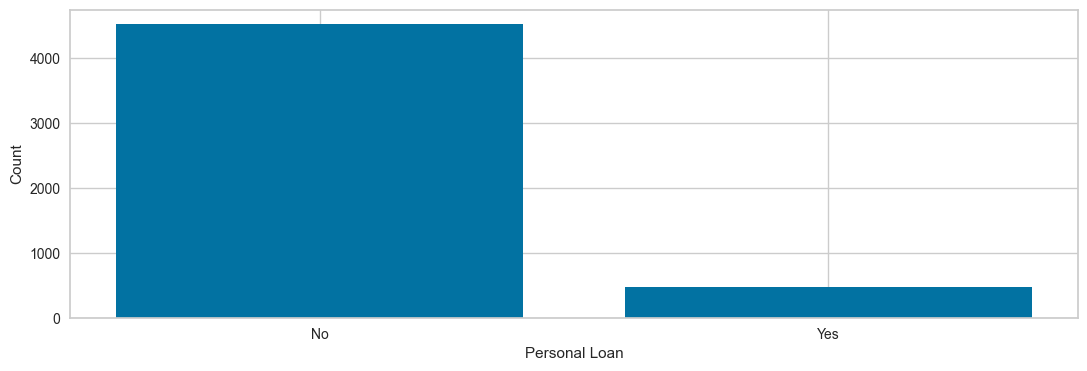

In [8]:
loan_counts = df['Personal.Loan'].value_counts()
plt.figure(figsize = (13, 4))
plt.bar(loan_counts.index, loan_counts.values)
plt.xlabel('Personal Loan')
plt.ylabel('Count')
plt.xticks(loan_counts.index, labels=['No', 'Yes'])
plt.show()

<div style="text-align: justify">
Con este gráfico de barras podemos observar un conteo rápido sobre nuestra variable de respuesta. Tenemos que alrededor de 4500 personas se les fue denegado el préstamo, mientras que las otras 500 personas fueron aceptadas, nos parece bastante interesante que los datos se comporten de esta manera, por lo profundizaremos en otras posibles variables que sean de vital importancia para entender este comportamiento

<Axes: >

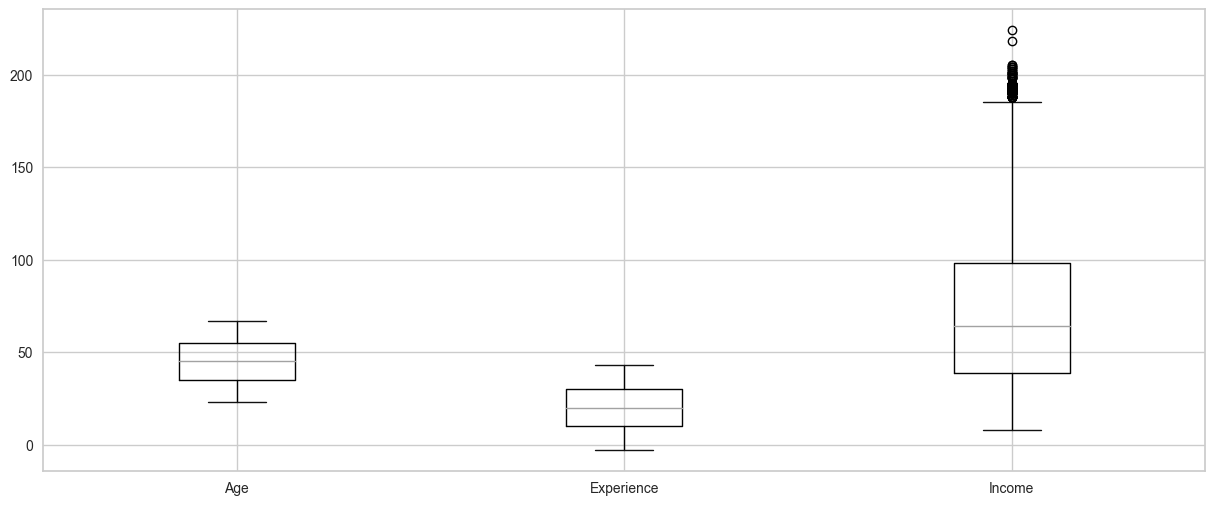

In [9]:
df[["Age", "Experience", "Income"]].boxplot(figsize = (15, 6))

<div style="text-align: justify">
Primeramente podemos observar que la edad de las personas registradas tiene una gran variedad, que va desde los 25 años aprox, hasta poco más de los 60 años. También podemos observar que la experiencia laboral también varía mucho, desde personas que llevan muchos años trabajando hasta personas que parece que han trabajo años negativos, esto por supuesto posiblemente generado a la hora de capturar los datos, por lo que en su debido momento haremos lo necesario para modificar este error. Por último, en los ingresos es donde podemos ver la mayor variedad de datos posibles, pues la persona con menor ingresos registrados es de 8 mil dólares anuales mientras que la máxima registrada es de 224 mil dólares al año, una diferencia de 216 mil dólares. Junto con las celdas anteriores, exploraremos otras posibles variables y su comportamiento.

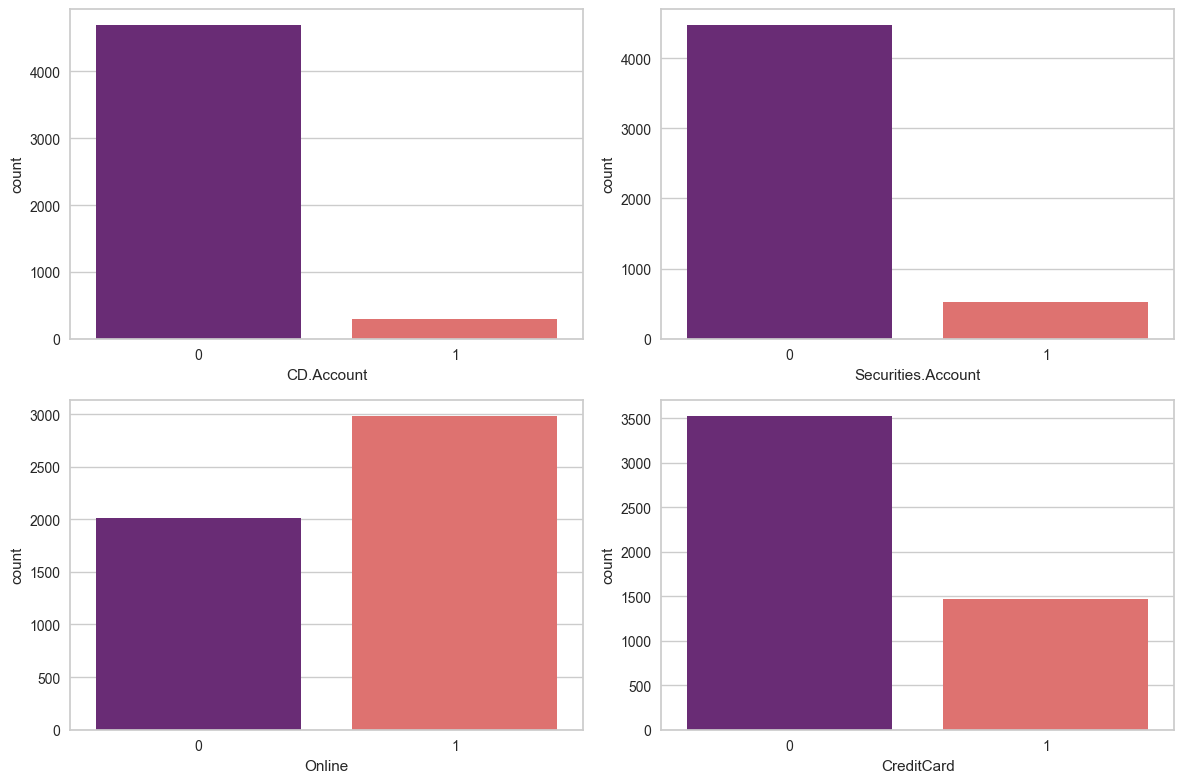

In [10]:
boolean_columns = [ 'CD.Account', 'Securities.Account', 'Online', 'CreditCard']
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))

sns.countplot(x = 'CD.Account', data = df, ax = axes[0, 0], palette = 'magma')
sns.countplot(x = 'Securities.Account', data = df, ax = axes[0,1], palette = 'magma')
sns.countplot(x = 'Online', data = df, ax = axes[1, 0], palette = 'magma')
sns.countplot(x = 'CreditCard', data = df, ax = axes[1, 1], palette = 'magma')

plt.tight_layout()
plt.show()

<div style="text-align: justify">
Con estos gráficos podemos observar que las primeras dos variables se comportan con mayor sentido a lo que es nuestra variable de respuesta, y tiene bastante sentido, dado que CD.Account indica si la persona tiene un certificado de cuenta de depósito con el banco, mientras que Securities.Account indica si el cliente tiene una cuenta de valores en el banco como acciones; podríamos decir que estás variables son de suma importancia pues los clientes tienen una mayor y mejor "reputación" con el banco al que solicitan el préstamo. Por último, comprobemos lo anteriormente mencionado con un mapa de correlación.

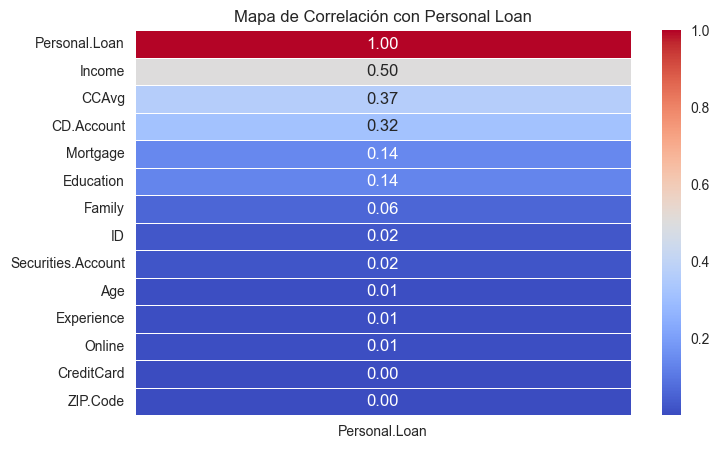

In [11]:
numeric_columns = df.select_dtypes(include = ['number'])
correlation = abs(numeric_columns.corr()[['Personal.Loan']]).sort_values(by = 'Personal.Loan', ascending = False)

plt.figure(figsize = (8, 5))
sns.heatmap(correlation, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths = .5)
plt.title('Mapa de Correlación con Personal Loan')
plt.show()

Con este gráfico podemos observar que las variables con mayor correlación a nuestra variable de respuesta son:

- Ingresos Anuales
- Promedio de gasto mensual en su tarjeta
- Variable binaria que indica si la persona tiene un certificado de cuenta de depósito

<div style="text-align: justify">
En general, podemos concluir que la variable de edad es la que mejor está distribuida. En cuanto a las variables de ingresos anuales, y promedio de gastos mensuales tienen un sesgo hacía la derecha por lo que es recomendable hacer una transformación aunque no estamos seguros de esto. La variable de ingresos anuales contiene muchos datos atípicos, la cual podría ser un problema, de no ser porque es "normal" hasta cierto punto tener un salario por encima del promedio.

En cuanto a las variables booleanas, se observa que la gran mayoría no tienen cuentas de débito en el banco, ni cuentas de acciones, además que muchas personas usan más el banco en línea que el banco tradicional físico.


<div id='id3'/>
    
## Modelado y Selección de Modelo

<div style="text-align: justify">
Previo al modelado, decidimos que a la columna de experiencia sacaremos los absolutos para deshacernos de los números negativos. Posteriormente removeremos la variable a predecir y haremos uso de la librería `SelectKBest` para elegir las 5 mejores variables y usar para los posteriores modelos

In [12]:
df['Experience'] = abs(df['Experience'])


X = df.drop(columns = ['Personal.Loan', 'zipCodeCity', 'zipCodeState', 'ZIP.Code', 'ID'])

y = df["Personal.Loan"]

selecKBest = SelectKBest(score_func = f_regression, k = 5)
selecKBest.fit(X, y)

variables = X.columns[selecKBest.get_support()]
print(variables)

Index(['Income', 'CCAvg', 'Education', 'Mortgage', 'CD.Account'], dtype='object')


In [13]:
numeric_features = ['Income', 'CCAvg', 'Mortgage']
categorical_features = ['Education', 'CD.Account']

s = setup(data = df[['Income', 'CCAvg', 'Education', 'Mortgage', 'CD.Account', 'Personal.Loan']],
          target='Personal.Loan',
          session_id = 123,
          numeric_features = numeric_features,
          categorical_features = categorical_features)

,Description,Value
0,Session id,123
1,Target,Personal.Loan
2,Target type,Binary
3,Original data shape,"(5000, 6)"
4,Transformed data shape,"(5000, 8)"
5,Transformed train set shape,"(3500, 8)"
6,Transformed test set shape,"(1500, 8)"
7,Numeric features,3
8,Categorical features,2
9,Preprocess,True


In [14]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9731,0.0000,0.7887,0.9211,0.8493,0.8347,0.8380,0.0310
gbc,Gradient Boosting Classifier,0.9709,0.0000,0.7737,0.9115,0.8347,0.8189,0.8235,0.0300
lightgbm,Light Gradient Boosting Machine,0.9706,0.0000,0.7977,0.8851,0.8383,0.8222,0.8240,0.4530
et,Extra Trees Classifier,0.9694,0.0000,0.7648,0.9018,0.8269,0.8103,0.8140,0.0230
dt,Decision Tree Classifier,0.9606,0.0000,0.7708,0.8120,0.7886,0.7669,0.7686,0.0080
ada,Ada Boost Classifier,0.9586,0.0000,0.6990,0.8410,0.7607,0.7383,0.7437,0.0150
lr,Logistic Regression,0.9557,0.0000,0.6278,0.8774,0.7291,0.7059,0.7191,0.1650
lda,Linear Discriminant Analysis,0.9380,0.0000,0.5771,0.7234,0.6402,0.6068,0.6125,0.0070
ridge,Ridge Classifier,0.9334,0.0000,0.3389,0.9115,0.4907,0.4634,0.5305,0.0070
knn,K Neighbors Classifier,0.9189,0.0000,0.3833,0.6273,0.4732,0.4323,0.4490,0.0110


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

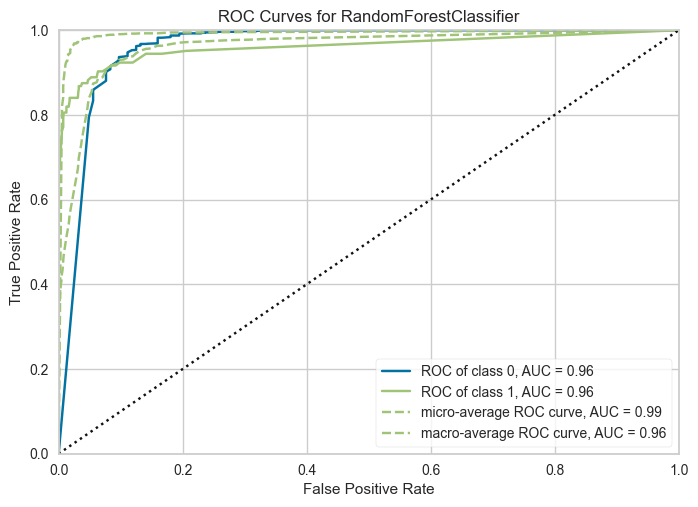

In [15]:
evaluate_model(best)

plot_model(best, plot = 'auc')

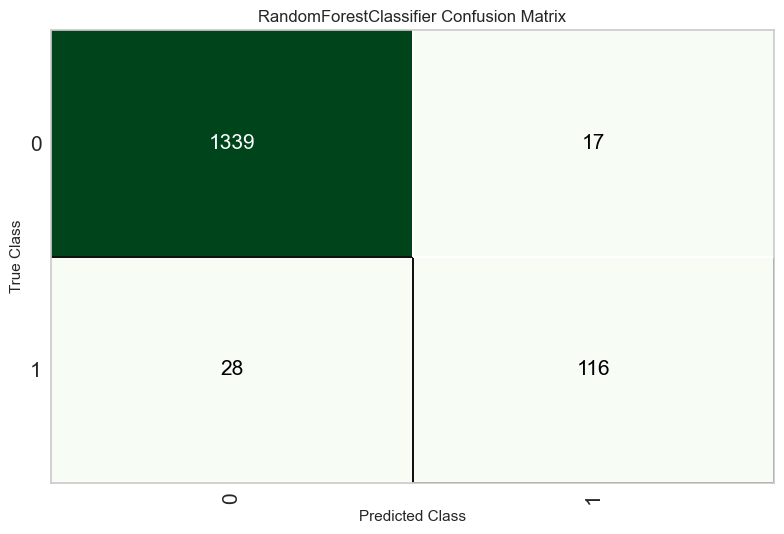

In [16]:
plot_model(best, plot = 'confusion_matrix')

In [17]:
predictions = predict_model(best, data=df)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9904,0.9896,0.9354,0.9635,0.9493,0.9440,0.9441


,ID,Age,Experience,Income,ZIP.Code,Family,CCAvg,Education,Mortgage,Securities.Account,CD.Account,Online,CreditCard,zipCodeCity,zipCodeState,Personal.Loan,prediction_label,prediction_score
0,1,25,1,49,91107,4,1.6,1,0,1,0,0,0,Pasadena,CA,0,0,1.0
1,2,45,19,34,90089,3,1.5,1,0,1,0,0,0,Los Angeles,CA,0,0,1.0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,Berkeley,CA,0,0,1.0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,San Francisco,CA,0,0,1.0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,1,Northridge,CA,0,0,1.0


In [18]:
save_model(best, 'RandomForestClassifier')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Income', 'CCAvg', 'Mortgage'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Education', 'C...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion

### Agrupaciones de Datos

Para esta parte del proyecto queremos profundizar en las variables significativas que cuenten con agrupaciones y ver sus desempeños frente al modelo propuesto en la parte anterior.

##### Ingresos

In [19]:
with open('RandomForestClassifier.pkl', 'rb') as archivo:
    modelo = pickle.load(archivo)

In [20]:
bins = [8, 44, 80, 116, 152, 188, 224]

df["Income_Group"] = pd.cut(df["Income"], bins = bins, labels = ['Grupo 1', 'Grupo 2', 'Grupo 3', 'Grupo 4', 'Grupo 5', 'Grupo 6'])

print(df[['ID', 'Income', 'Income_Group']])

        ID  Income Income_Group
0        1      49      Grupo 2
1        2      34      Grupo 1
2        3      11      Grupo 1
3        4     100      Grupo 3
4        5      45      Grupo 2
...    ...     ...          ...
4995  4996      40      Grupo 1
4996  4997      15      Grupo 1
4997  4998      24      Grupo 1
4998  4999      49      Grupo 2
4999  5000      83      Grupo 3

[5000 rows x 3 columns]


In [21]:
# Cargar el modelo desde el archivo .pkl
modelo = joblib.load('RandomForestClassifier.pkl')

# Iterar sobre cada grupo de datos (cada grupo de experiencia laboral)
for grupo, datos_grupo in df.groupby('Income_Group'):
    print("Grupo de Ingresos:", grupo)

    # Dividir los datos del grupo en características y variable objetivo
    X_grupo = datos_grupo[['Income', 'CCAvg', 'Education', 'Mortgage', 'CD.Account']]
    y_grupo = datos_grupo['Personal.Loan']

    # Dividir los datos del grupo en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_grupo, y_grupo, test_size=0.2, random_state=42)

    # Hacer predicciones en el conjunto de prueba
    predicciones = modelo.predict(X_test)

    # Calcular métricas de evaluación
    reporte = classification_report(y_test, predicciones)
    print("Reporte de clasificación:")
    print(reporte)

    # Generar matriz de confusión
    matriz_confusion = confusion_matrix(y_test, predicciones)
    print("Matriz de confusión:")
    print(matriz_confusion)
    print("\n")

Grupo de Ingresos: Grupo 1
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       337

    accuracy                           1.00       337
   macro avg       1.00      1.00      1.00       337
weighted avg       1.00      1.00      1.00       337

Matriz de confusión:
[[337]]


Grupo de Ingresos: Grupo 2
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285

Matriz de confusión:
[[285]]


Grupo de Ingresos: Grupo 3
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       169
           1       0.89      0.81      0.85        21

    accuracy                           0.97       190
   macro avg   

##### Educación

In [22]:
# Iterar sobre cada grupo de datos (cada rango de edad)
for grupo, datos_grupo in df.groupby('Education'):
    print("Education:", grupo)

    # Dividir los datos del grupo en características y variable objetivo
    X_grupo = datos_grupo[['Income', 'CCAvg', 'Education', 'Mortgage', 'CD.Account']]
    y_grupo = datos_grupo['Personal.Loan']

    # Dividir los datos del grupo en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_grupo, y_grupo, test_size=0.2, random_state=42)

    # Hacer predicciones en el conjunto de prueba
    predicciones = modelo.predict(X_test)

    # Calcular métricas de evaluación
    reporte = classification_report(y_test, predicciones)
    print("Reporte de clasificación:")
    print(reporte)

    # Generar matriz de confusión
    matriz_confusion = confusion_matrix(y_test, predicciones)
    print("Matriz de confusión:")
    print(matriz_confusion)
    print("\n")

Education: 1
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.95      0.84      0.89        25

    accuracy                           0.99       420
   macro avg       0.97      0.92      0.94       420
weighted avg       0.99      0.99      0.99       420

Matriz de confusión:
[[394   1]
 [  4  21]]


Education: 2
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       0.97      1.00      0.99        38

    accuracy                           1.00       281
   macro avg       0.99      1.00      0.99       281
weighted avg       1.00      1.00      1.00       281

Matriz de confusión:
[[242   1]
 [  0  38]]


Education: 3
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       260
           1       1.00     

##### Edad

In [23]:
# Definir los límites de los rangos de edad
bins = [20, 30, 40, 50, 60, float('inf')]  # Rangos de edad: 0-20, 21-30, 31-40, 41-50, 51-60, 60+

# Definir los nombres de las categorías
labels = ['21-30', '31-40', '41-50', '51-60', '61+']

# Crear una nueva columna en el DataFrame que contenga los rangos de edad
df['Rango de Edad'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Agrupar los datos por los rangos de edad
grupo_por_edad = df.groupby('Rango de Edad').size()

print(grupo_por_edad)

Rango de Edad
21-30     488
31-40    1247
41-50    1257
51-60    1334
61+       674
dtype: int64


In [24]:
# Iterar sobre cada grupo de datos (cada rango de edad)
for grupo, datos_grupo in df.groupby('Rango de Edad'):
    print("Rango de Edad:", grupo)

    # Dividir los datos del grupo en características y variable objetivo
    X_grupo = datos_grupo[['Income', 'CCAvg', 'Education', 'Mortgage', 'CD.Account']]
    y_grupo = datos_grupo['Personal.Loan']

    # Dividir los datos del grupo en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_grupo, y_grupo, test_size=0.2, random_state=42)

    # Hacer predicciones en el conjunto de prueba
    predicciones = modelo.predict(X_test)

    # Calcular métricas de evaluación
    reporte = classification_report(y_test, predicciones)
    print("Reporte de clasificación:")
    print(reporte)

    # Generar matriz de confusión
    matriz_confusion = confusion_matrix(y_test, predicciones)
    print("Matriz de confusión:")
    print(matriz_confusion)
    print("\n")

Rango de Edad: 21-30
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        88
           1       1.00      0.90      0.95        10

    accuracy                           0.99        98
   macro avg       0.99      0.95      0.97        98
weighted avg       0.99      0.99      0.99        98

Matriz de confusión:
[[88  0]
 [ 1  9]]


Rango de Edad: 31-40
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       224
           1       1.00      0.92      0.96        26

    accuracy                           0.99       250
   macro avg       1.00      0.96      0.98       250
weighted avg       0.99      0.99      0.99       250

Matriz de confusión:
[[224   0]
 [  2  24]]


Rango de Edad: 41-50
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       240
        

<div id='id4'/>
    
## Aplicación de Técnicas Fairness

In [25]:
sensitive_features = X['Education']
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, sensitive_features, random_state = 123)

# Instancia un clasificador RandomForestClassifier
clf = RandomForestClassifier()

# Entrena el clasificador
clf.fit(X_train, y_train)

# Calcula la tasa de selección y la diferencia de paridad demográfica
selection_rate_result = selection_rate(y_test, clf.predict(X_test))
demographic_parity_difference_result = demographic_parity_difference(y_test, clf.predict(X_test), sensitive_features = A_test)

# imprime los resultados
print(f'Selection rate: {selection_rate_result}')
print(f'Demographic parity difference: {demographic_parity_difference_result}')

Selection rate: 0.0888
Demographic parity difference: 0.11728565131143928


In [26]:
threshold_optimizer = ThresholdOptimizer(
    estimator=clf,
    constraints="demographic_parity",
    predict_method="predict_proba",
    prefit=False,
)

threshold_optimizer.fit(X_train, y_train, sensitive_features=A_train)

ThresholdOptimizer(constraints='demographic_parity',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='sqrt',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    monotonic_cst=None,
                                                    n_estimators=100,
                                                    n_jobs=None,
                                                    oob_score=False,
                                                    random_state=None,
                                                    verbose=0,
                                                    warm_start=False),
                   flip=False, grid_size=1000, objective='accuracy_score',
                   predict_method='predict_proba', prefit=False)

{
    "1": {
        "p0": 0.9285450901803608,
        "operation0": "[>0.14500000000000002]",
        "p1": 0.0714549098196392,
        "operation1": "[>-inf]"
    },
    "2": {
        "p0": 0.20933333333332974,
        "operation0": "[>0.685]",
        "p1": 0.7906666666666703,
        "operation1": "[>0.43]"
    },
    "3": {
        "p0": 0.08222222222222207,
        "operation0": "[>inf]",
        "p1": 0.9177777777777779,
        "operation1": "[>0.805]"
    }
}


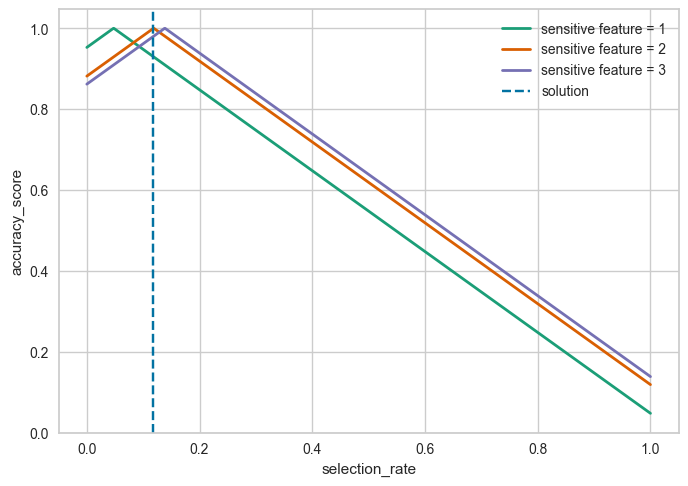

In [27]:
y_pred_opt = threshold_optimizer.predict(X_test, sensitive_features=A_test)

print(
    json.dumps(
        threshold_optimizer.interpolated_thresholder_.interpolation_dict,
        default=str,
        indent=4,
    )
)

plot_threshold_optimizer(threshold_optimizer)

In [28]:
m_dpr_opt = demographic_parity_ratio(y_test, y_pred_opt, sensitive_features=A_test)
m_eqo_opt = equalized_odds_ratio(y_test, y_pred_opt, sensitive_features=A_test)
print(f'Value of demographic parity ratio (after post-processing): {round(m_dpr_opt, 2)}')
print(f'Value of equal odds ratio (after post-processing): {round(m_eqo_opt, 2)}')

Value of demographic parity ratio (after post-processing): 0.56
Value of equal odds ratio (after post-processing): 0.0


In [29]:
dp = DemographicParity()
classifier = RandomForestClassifier()

# Entrenamiento del modelo con la técnica Exponentiated Gradient
fair_clf = ExponentiatedGradient(classifier, dp)
fair_clf.fit(X_train, y_train, sensitive_features=A_train)

# Predicciones con el modelo mitigado
y_pred_fair = fair_clf.predict(X_test)

# Evaluación de la precisión y equidad del modelo mitigado
accuracy_fair = accuracy_score(y_test, y_pred_fair)
dpr_fair = demographic_parity_ratio(y_test, y_pred_fair, sensitive_features=A_test)
print(f'Accuracy of fair model: {accuracy_fair}')
print(f'Demographic parity ratio of fair model: {dpr_fair}')

Accuracy of fair model: 0.9552
Demographic parity ratio of fair model: 0.6453402366863905


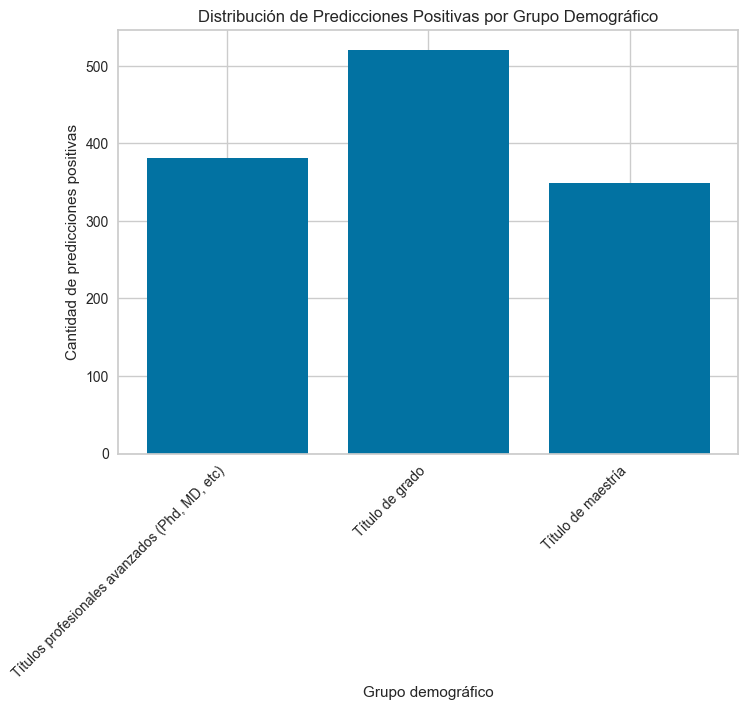

In [30]:
# Diccionario de mapeo de valores numéricos a etiquetas descriptivas
mapping_dict = {
    1: 'Título de grado',
    2: 'Título de maestría',
    3: 'Títulos profesionales avanzados (Phd, MD, etc)'
}

# Convertir los valores numéricos en etiquetas descriptivas para los datos sensibles
sensitive_features_labels = [mapping_dict[value] for value in A_test]

# Agrupar las predicciones positivas por grupo demográfico
positive_predictions = y_pred_fair[y_pred_fair == 1]

# predicciones positivas por grupo demográfico
count_by_group = {}
for group in set(sensitive_features_labels):
    count_by_group[group] = np.sum(np.array(sensitive_features_labels) == group)

# Graficar la distribución de las predicciones positivas por grupo demográfico
plt.bar(count_by_group.keys(), count_by_group.values())
plt.xlabel('Grupo demográfico')
plt.ylabel('Cantidad de predicciones positivas')
plt.title('Distribución de Predicciones Positivas por Grupo Demográfico')
plt.xticks(rotation=45, ha='right')
plt.show()

<div id='id5'/>
    
## Conclusiones